# Parameters

In [1]:
import src as xc 
import cptdl as dl 
import cptio as cio
import datetime as dt 
import xarray as xr 
from pathlib import Path 
import cartopy.crs as ccrs 
import matplotlib.pyplot as plt 

download_args = { 
  'fdate': dt.datetime(2022, 5, 1),  
  'first_year': 1991, 
  'final_year': 2020, 
  'predictor_extent': {'east': 100, 'west': 60,  'north': 35, 'south': 0}, 
  'predictand_extent': {'east': 100, 'west': 60,  'north': 35, 'south': 0}, 
  'lead_low': 1.5,
  'lead_high': 3.5, 
  'target': 'Jun-Aug',
  'filetype': 'cptv10.tsv',
  'ensemblemean': False
}

gcms = [  'CCSM4.PRCP', 'CanSIPSIC3.PRCP']
observations = 'UCSB.PRCP'



# Download Observations

In [2]:
# Download Observations 
if not Path('{}.tsv'.format(observations)).is_file():
    print('STARTING DOWNLOAD OF {}'.format(observations))
    Y = dl.download(dl.observations[observations], '{}.tsv'.format(observations), **download_args, verbose=True, use_dlauth=False)
    Y = getattr(Y, [i for i in Y.data_vars][0]).expand_dims({'M':[observations]})
    print()
else:
    Y = cio.open_cptdataset('{}.tsv'.format(observations))
    Y = getattr(Y, [i for i in Y.data_vars][0]).expand_dims({'M':[0]})

# Download GCMS

In [3]:
# Download GCMs
models = []
for gcm in gcms:
    if not Path('{}.tsv'.format(gcm)).is_file():
        print('STARTING DOWNLOAD OF {}'.format(gcm))
        g = dl.download(dl.hindcasts[gcm], '{}.tsv'.format(gcm), **download_args, verbose=True, use_dlauth=False)
        g = getattr(g, [i for i in g.data_vars][0])
        print()
    else:
        print('LOADING {} FROM FILE'.format(gcm))
        g = cio.open_cptdataset('{}.tsv'.format(gcm))
        g = getattr(g, [i for i in g.data_vars][0])
        print()

    
    g = xc.regrid(g, Y.coords['X'].values, Y.coords['Y'].values)
    models.append(g)



LOADING CCSM4.PRCP FROM FILE

LOADING CanSIPSIC3.PRCP FROM FILE



# Evaluate Ensemble-Mean Deterministic Forecasts

### Plot Taylor Diagram


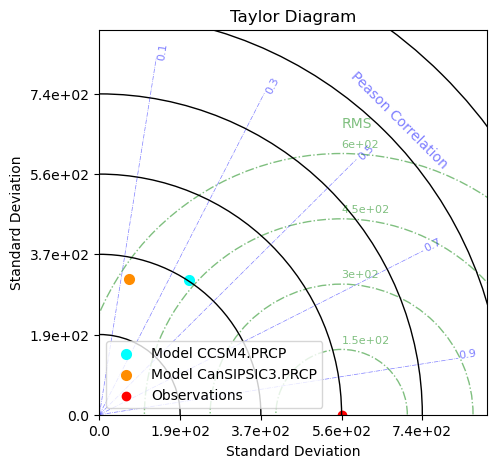

In [4]:
means = xr.concat([i.mean('M') for i in models], 'M').assign_coords({'M':gcms})
xc.view_taylor(means, Y)

### Plot Spatial Patterns

OBSERVATIONS


/var/folders/m6/v31d2h_s0tzc6pn_nvz43mrr0000gp/T/ipykernel_97245/1493964742.py:6: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in pl.axes.flat:


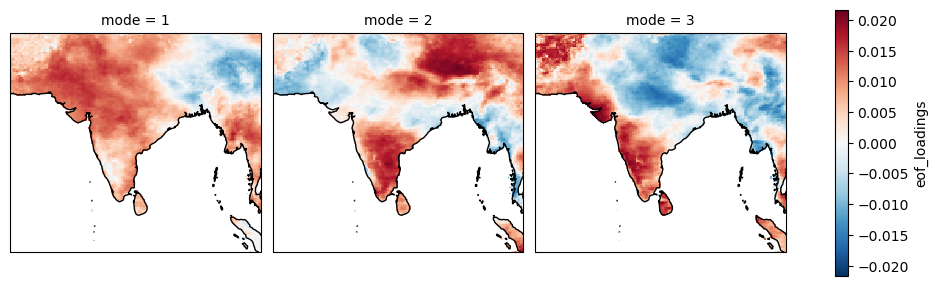

CCSM4.PRCP


/var/folders/m6/v31d2h_s0tzc6pn_nvz43mrr0000gp/T/ipykernel_97245/1493964742.py:15: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in pl.axes.flat:


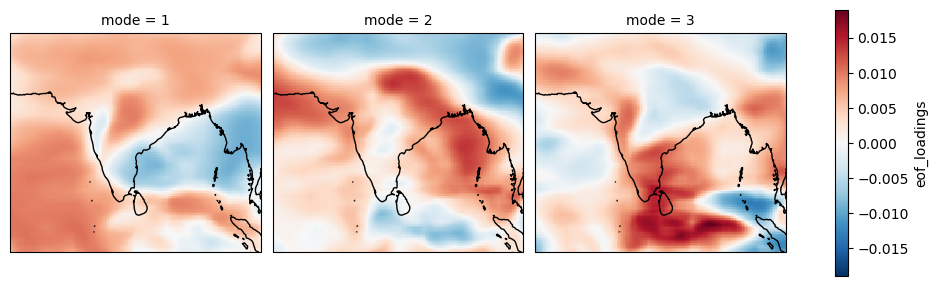

CanSIPSIC3.PRCP


/var/folders/m6/v31d2h_s0tzc6pn_nvz43mrr0000gp/T/ipykernel_97245/1493964742.py:15: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in pl.axes.flat:


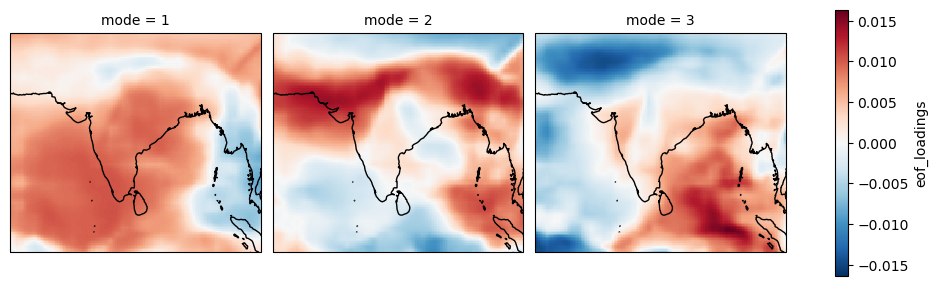

In [10]:
modes = 3
print('OBSERVATIONS')
eof = xc.EOF(latitude_weighting=True)
eof.fit(Y)
pl = eof.eof_loadings.isel(mode=slice(0, modes)).plot(subplot_kws={'projection':ccrs.PlateCarree()}, col="mode", col_wrap=modes)
for ax in pl.axes.flat:
    ax.coastlines()
plt.show()
    
for i, model in enumerate(models): 
    print('{}'.format(gcms[i]))
    eof = xc.EOF(latitude_weighting=True)
    eof.fit(model.mean('M').expand_dims({'M':[0]}))
    pl = eof.eof_loadings.isel(mode=slice(0, modes)).plot(subplot_kws={'projection':ccrs.PlateCarree()}, col="mode", col_wrap=modes)
    for ax in pl.axes.flat:
        ax.coastlines()
    plt.show()

### Plot Deterministic Skill Scores

/var/folders/m6/v31d2h_s0tzc6pn_nvz43mrr0000gp/T/ipykernel_97245/1670874140.py:10: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in pl.axes.flat:
/var/folders/m6/v31d2h_s0tzc6pn_nvz43mrr0000gp/T/ipykernel_97245/1670874140.py:22: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in pl.axes.flat:
/var/folders/m6/v31d2h_s0tzc6pn_nvz43mrr0000gp/T/ipykernel_97245/1670874140.py:34: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in pl.axes.flat:


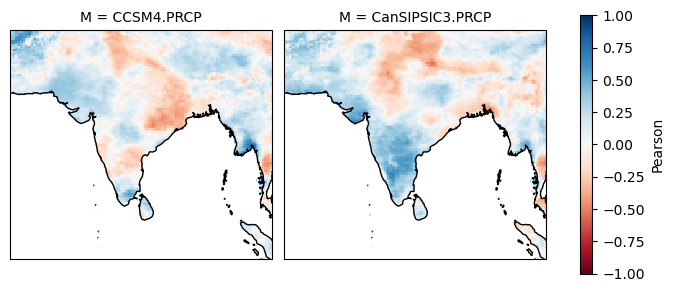

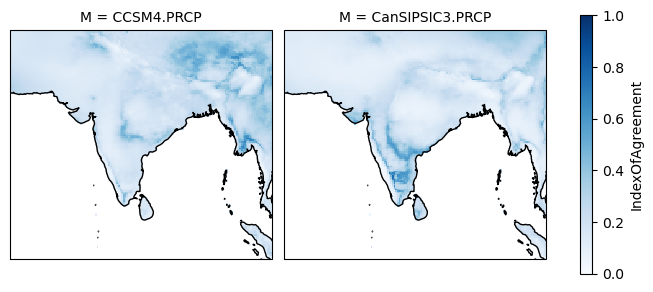

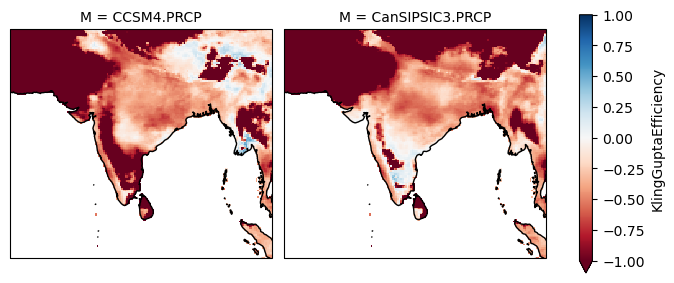

In [11]:

pearsons = []
for model in models: 

    pearson = xc.Pearson(model.mean('M').expand_dims({'M':[0]}), Y)
    pearsons.append(pearson)

pearsons = xr.concat(pearsons, 'M').assign_coords({'M': gcms})

pl = pearsons.plot(col='M', col_wrap=2, cmap='RdBu', vmin=-1, vmax=1, subplot_kws={'projection': ccrs.PlateCarree()})
for ax in pl.axes.flat:
    coasts = ax.coastlines()
    
ioas = []
for model in models: 

    ioa = xc.IndexOfAgreement(model.mean('M').expand_dims({'M':[0]}), Y)
    ioas.append(ioa)

ioas = xr.concat(ioas, 'M').assign_coords({'M': gcms})

pl = ioas.plot(col='M', col_wrap=2, cmap='Blues', vmin=0, vmax=1, subplot_kws={'projection': ccrs.PlateCarree()})
for ax in pl.axes.flat:
    coasts = ax.coastlines()
    
kges = []
for model in models: 

    kge = xc.KlingGuptaEfficiency(model.mean('M').expand_dims({'M':[0]}), Y)
    kges.append(kge)

kges = xr.concat(kges, 'M').assign_coords({'M': gcms})

pl = kges.plot(col='M', col_wrap=2, cmap='RdBu', vmin=-1, vmax=1, subplot_kws={'projection': ccrs.PlateCarree()})
for ax in pl.axes.flat:
    coasts = ax.coastlines() 

# Compute Member-Count Tercile Probabilistic Forecasts

In [5]:
model_member_count = []
for model in models:
    prob_model = []
    i =1
    for x_train, y_train, x_test, y_test in xc.CrossValidator(model, Y, window=1):
        print('starting round {}'.format(i))
        i+=1
        mc = xc.cMemberCount()
        mc.fit(x_train, y_train)
        probs = mc.predict_proba(x_test)
        prob_model.append(probs)
    prob_model=xr.concat(prob_model, 'T')
    model_member_count.append(prob_model)
    


starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round 1
starting round

# Evaluate Probabilistic Forecasts 

/Users/khall/Desktop/xcast/src/verification/flat_metrics.py:26: RuntimeWarning: invalid value encountered in divide
  hit_scores = numerators / denominators
/Users/khall/Desktop/xcast/src/verification/flat_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(hit_scores) / pairs.shape[0]
/Users/khall/Desktop/xcast/src/verification/flat_metrics.py:26: RuntimeWarning: invalid value encountered in divide
  hit_scores = numerators / denominators
/Users/khall/Desktop/xcast/src/verification/flat_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(hit_scores) / pairs.shape[0]
/var/folders/m6/v31d2h_s0tzc6pn_nvz43mrr0000gp/T/ipykernel_97674/2665313078.py:22: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in pl.axes.flat:
/var/folders/m6/v31d2h_s0tzc6pn_nvz43mrr0000gp/T/ipykernel_97674/2665313078.py:38: DeprecationWarning: self.ax

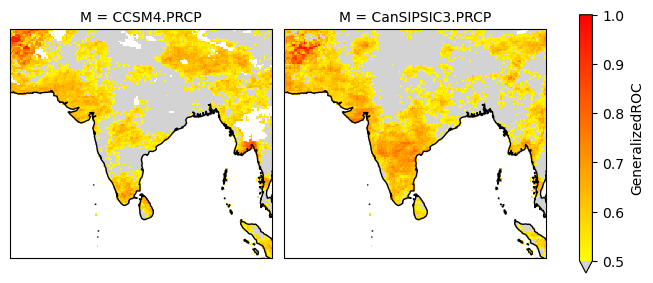

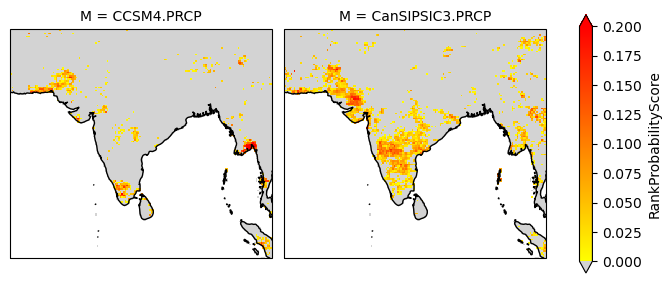

In [6]:
import matplotlib.pyplot as plt 

# compute ground truth terciles 
rt = xc.RankedTerciles() 
rt.fit(Y)
T = rt.transform(Y)

climo_rps = xc.RankProbabilityScore(xr.ones_like(T) * 0.333, T)

cmapg = plt.get_cmap('autumn_r').copy()
cmapg.set_under('lightgray')

grocs = []
for membercount in model_member_count: 

    groc = xc.GeneralizedROC(membercount, T)
    grocs.append(groc)

grocs = xr.concat(grocs, 'M').assign_coords({'M': gcms})

pl = grocs.plot(col='M', col_wrap=len(gcms), cmap=cmapg, vmin=0.5, vmax=1, subplot_kws={'projection': ccrs.PlateCarree()})
for ax in pl.axes.flat:
    coasts = ax.coastlines()
    
rpsss = []
for membercount in model_member_count: 

    rps = xc.RankProbabilityScore(membercount, T)
    rpss = 1 - (rps / climo_rps)
    rpsss.append(rpss)

rpsss = xr.concat(rpsss, 'M').assign_coords({'M': gcms})

cmap = plt.get_cmap('autumn_r').copy()
cmap.set_under('lightgray')

pl = rpsss.plot(col='M', col_wrap=len(gcms), cmap=cmap, vmin=0, vmax=0.2, subplot_kws={'projection': ccrs.PlateCarree()})
for ax in pl.axes.flat:
    coasts = ax.coastlines()
    

RELIABILITY (WHEN GROC > 0.5) FOR CCSM4.PRCP


/Users/khall/Desktop/xcast/src/visualization/reliability.py:113: RuntimeWarning: Mean of empty slice
  br = np.nanmean((base_rate - t)**2)


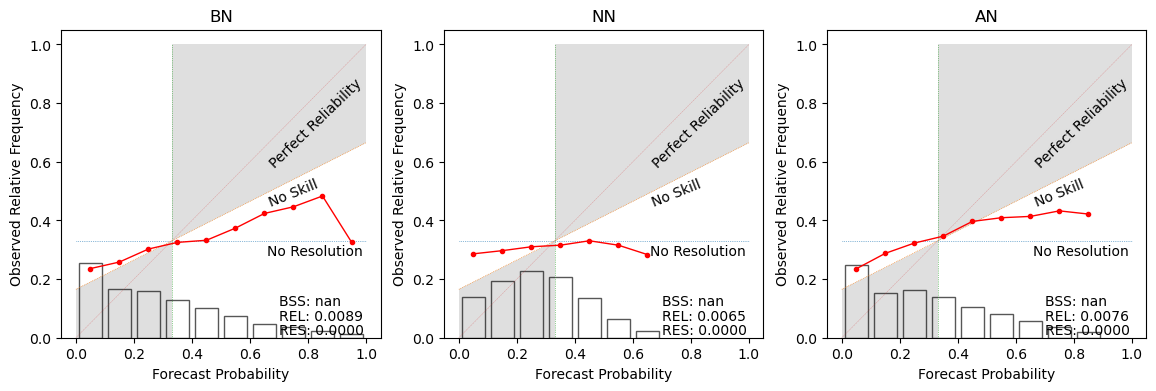

RELIABILITY (WHEN GROC > 0.5) FOR CanSIPSIC3.PRCP


/Users/khall/Desktop/xcast/src/visualization/reliability.py:113: RuntimeWarning: Mean of empty slice
  br = np.nanmean((base_rate - t)**2)


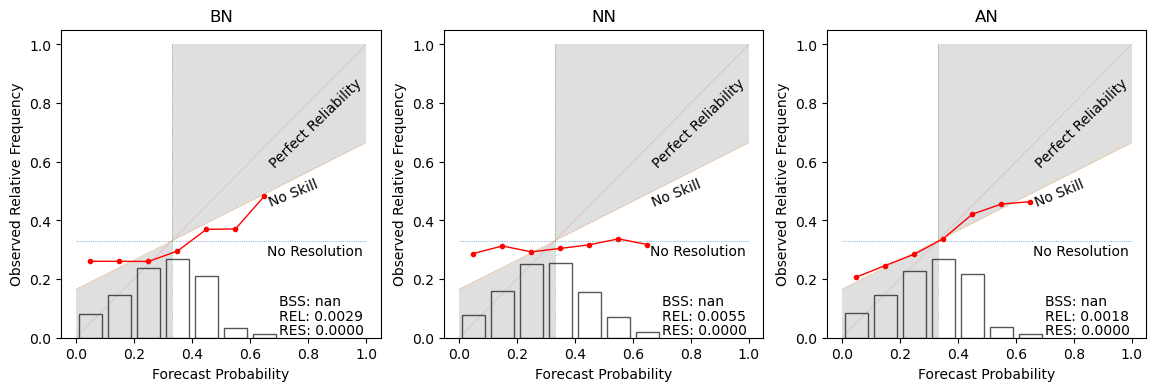

In [7]:
import numpy as np
for i, mc in enumerate(model_member_count):
    print('RELIABILITY (WHEN GROC > 0.5) FOR {}'.format(gcms[i]))
    groc = grocs.sel(M=gcms[i])
    mask = xr.ones_like(groc).where(groc > 0.5, other=np.nan).mean('SKILLDIM')
    xc.view_reliability(mc * mask, T)
    plt.show()


# Compute PAC Tercile Probabilistic Forecasts

In [4]:
model_member_count = []
for model in models:
    prob_model = []
    i =1
    for x_train, y_train, x_test, y_test in xc.CrossValidator(model, Y, window=1):
        print('starting round {}'.format(i))
        i+=1
        mc = xc.cProbabilityAnomalyCorrelation()
        mc.fit(x_train, y_train)
        probs = mc.predict_proba(x_test)
        prob_model.append(probs)
    prob_model=xr.concat(prob_model, 'T')
    model_member_count.append(prob_model)
    

/Users/khall/miniconda3/envs/xcast/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/Users/khall/Desktop/xcast/src/verification/flat_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(hit_scores) / pairs.shape[0]
/Users/khall/miniconda3/envs/xcast/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/Users/khall/Desktop/xcast/src/verification/flat_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(hit_scores) / pairs.shape[0]
/var/folders/m6/v31d2h_s0tzc6pn_nvz43mrr0000gp/T/ipykernel_98344/1423322478.py:22: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in pl.axes.flat:
/Users/khall/miniconda3/envs/xcast/lib/python3.10/site-packages/dask/arr

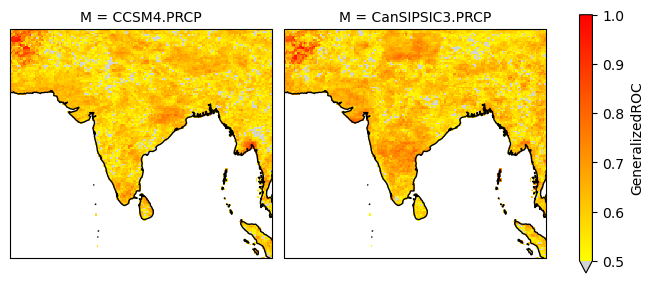

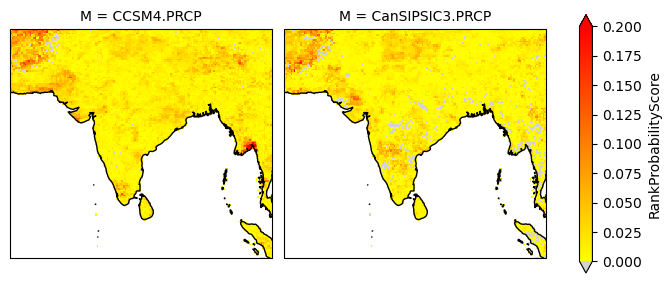

In [5]:
import matplotlib.pyplot as plt 

# compute ground truth terciles 
rt = xc.RankedTerciles() 
rt.fit(Y)
T = rt.transform(Y)

climo_rps = xc.RankProbabilityScore(xr.ones_like(T) * 0.333, T)

cmapg = plt.get_cmap('autumn_r').copy()
cmapg.set_under('lightgray')

grocs = []
for membercount in model_member_count: 

    groc = xc.GeneralizedROC(membercount, T)
    grocs.append(groc)

grocs = xr.concat(grocs, 'M').assign_coords({'M': gcms})

pl = grocs.plot(col='M', col_wrap=len(gcms), cmap=cmapg, vmin=0.5, vmax=1, subplot_kws={'projection': ccrs.PlateCarree()})
for ax in pl.axes.flat:
    coasts = ax.coastlines()
    
rpsss = []
for membercount in model_member_count: 

    rps = xc.RankProbabilityScore(membercount, T)
    rpss = 1 - (rps / climo_rps)
    rpsss.append(rpss)

rpsss = xr.concat(rpsss, 'M').assign_coords({'M': gcms})

cmap = plt.get_cmap('autumn_r').copy()
cmap.set_under('lightgray')

pl = rpsss.plot(col='M', col_wrap=len(gcms), cmap=cmap, vmin=0, vmax=0.2, subplot_kws={'projection': ccrs.PlateCarree()})
for ax in pl.axes.flat:
    coasts = ax.coastlines()

RELIABILITY (WHEN GROC > 0.5) FOR CCSM4.PRCP


/Users/khall/miniconda3/envs/xcast/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


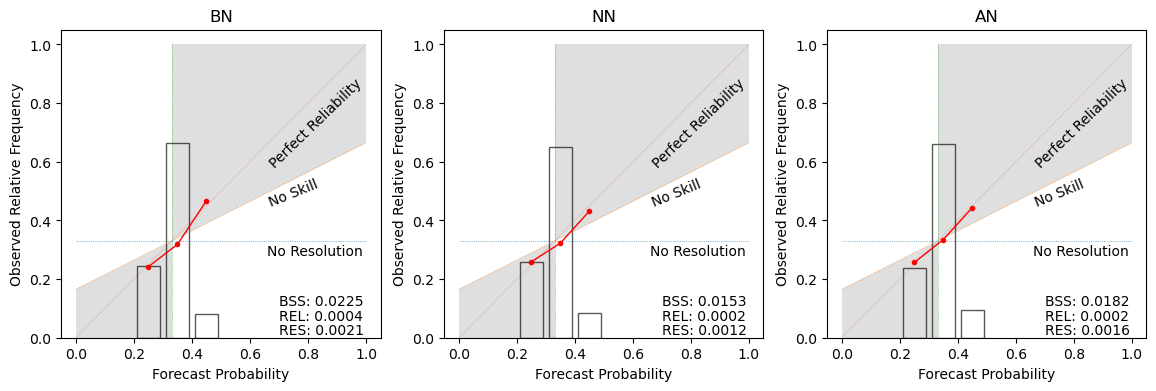

RELIABILITY (WHEN GROC > 0.5) FOR CanSIPSIC3.PRCP


/Users/khall/miniconda3/envs/xcast/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


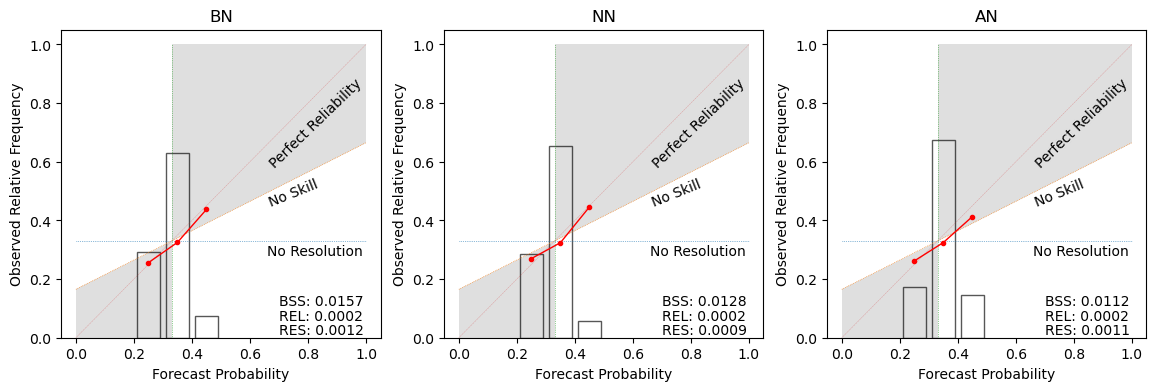

In [6]:
import numpy as np
for i, mc in enumerate(model_member_count):
    print('RELIABILITY (WHEN GROC > 0.5) FOR {}'.format(gcms[i]))
    groc = grocs.sel(M=gcms[i])
    mask = xr.ones_like(groc).where(groc > 0.5, other=np.nan).mean('SKILLDIM')
    xc.view_reliability(mc * mask, T)
    plt.show()

